# Fractional Cover Percentiles
 
| Authors:  | Bex Dunn| Vanessa Newey | Imam Alam |
|----------|----------------|
| Created: |                      August 13, 2018 |

__Background:__ [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data is stored in DEA. More information on *Fractional Cover* can be found in the *'Introduction to Fractional Cover'* notebook.

__What does this notebook do?:__ This notebook demonstrates using Fractional Cover Percentiles (calculated using datacube stats).The data is then saved to NetCDF and GeoTIFF for analysis elsewhere.

## Import modules from standard libraries, datacube and files

In [3]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf
from datacube_stats.statistics import Percentile
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser ## this is the group_by for wofs! 
# Import external functions from dea-notebooks --note Scripts directory has moved recently
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-FC')

### Specify the *query* with the coordinates and date range

In [2]:
#the query is a dictionary where the keys are the spatio-temporal specs
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2015-01-01', '2017-01-31')
        }

## load the data according to our query


In [5]:
ds = DEADataHandling.load_clearlandsat(dc, query,product='fc')

Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 0 filtered ls7 timesteps
Loading ls8 PQ
    Loading 15 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


### Plot Fractional Cover and Unmixing Error Bands
Note that Unmixing Error is high over water

In [6]:
#just a scene we want to plot - this can be done other ways
scene = 0

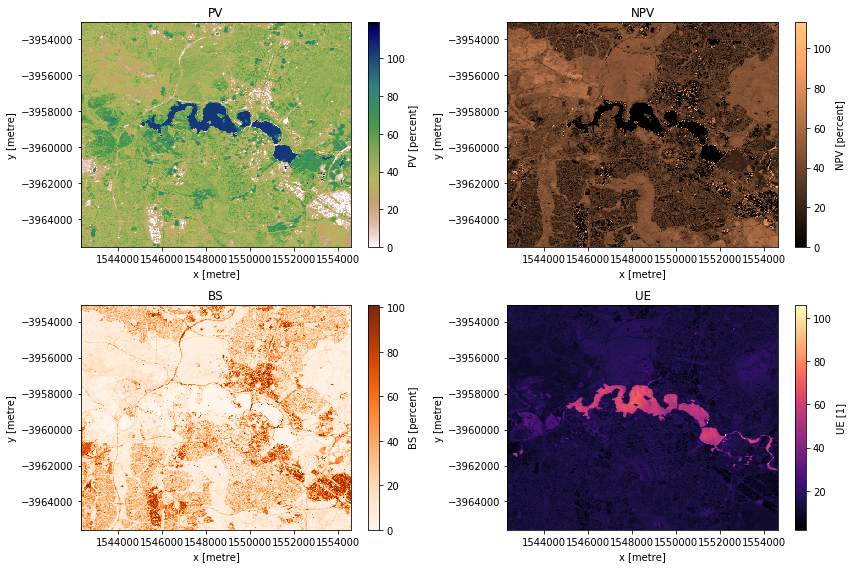

In [7]:
#set up our images on a grid using gridspec
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
ds.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
ds.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
ds.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'

In [8]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'wofs_albers', like=ds, group_by='solar_day', fuse_func=wofs_fuser)

## Remove areas of water from the Fractional Cover dataset

In [28]:
wetwofl = masking.make_mask(wofls, wet=True)
#match WOFL times to our fractional cover times
unwofld = ds.where(ds.time == wetwofl.time)
#mask out water from fractional cover
unwofld = unwofld.where(wetwofl.water==False, drop=False)
del wofls

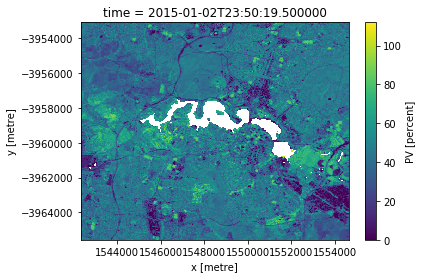

In [11]:
unwofld.isel(time=0).PV.plot()

## Calculate percentiles of Fractional Cover
This can be done on the command line using datacube-stats, but this notebook demonstrates how to do it in a notebook. The Percentile function can be used on any dataset, but requires you to create an object and then 'compute' it. 

### Specify percentiles to calculate

In [30]:
#edit this list if you want different quantiles/percentiles 
percentiles = [0, 5, 20, 50, 80, 95, 100]

## Calculate percentiles

In [32]:
# drop unmixing error and data percentage, which make no sense as quantiles
unwofld =unwofld.drop(['UE', 'data_perc'])

In [33]:
unwofld

<xarray.Dataset>
Dimensions:  (time: 15, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-02T23:50:19.500000 ...
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    BS       (time, y, x) float64 18.0 25.0 31.0 28.0 32.0 31.0 27.0 26.0 ...
    PV       (time, y, x) float64 45.0 45.0 46.0 53.0 50.0 48.0 54.0 51.0 ...
    NPV      (time, y, x) float64 36.0 29.0 22.0 19.0 17.0 21.0 19.0 21.0 ...
Attributes:
    crs:      EPSG:3577

### create Percentile object

In [35]:
FC_percents =Percentile(percentiles)   

### compute percentiles

In [36]:
FC_percentiles = FC_percents.compute(unwofld)

### reattach attributes

In [45]:
#reattatch attributes here
FC_percentiles.attrs = unwofld.attrs

In [46]:
FC_percentiles

<xarray.Dataset>
Dimensions:     (x: 492, y: 500)
Coordinates:
  * y           (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x           (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    BS_PC_0     (y, x) float64 14.0 21.0 31.0 28.0 21.0 26.0 23.0 19.0 13.0 ...
    PV_PC_0     (y, x) float64 41.0 37.0 36.0 36.0 31.0 30.0 37.0 39.0 44.0 ...
    NPV_PC_0    (y, x) float64 29.0 19.0 8.0 5.0 8.0 4.0 7.0 15.0 20.0 17.0 ...
    BS_PC_5     (y, x) float64 14.0 24.0 33.0 30.0 27.0 31.0 26.0 24.0 14.0 ...
    PV_PC_5     (y, x) float64 42.0 39.0 39.0 37.0 34.0 33.0 38.0 40.0 45.0 ...
    NPV_PC_5    (y, x) float64 30.0 20.0 8.0 6.0 16.0 4.0 8.0 16.0 23.0 20.0 ...
    BS_PC_20    (y, x) float64 14.0 27.0 38.0 33.0 32.0 36.0 30.0 30.0 16.0 ...
    PV_PC_20    (y, x) float64 42.0 41.0 40.0 40.0 38.0 34.0 43.0 44.0 46.0 ...
    NPV_PC_20   (y, x) float64 33.0 22.0 9.0 12.0 16.0 6.0 9.0 17.0 25.0 ...
    BS_PC_50    (y, x) float64 18.0 30.0 45.0 42.0 36.0

## Plot percentiles

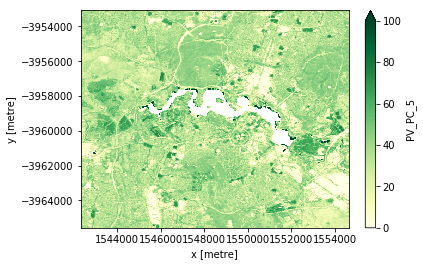

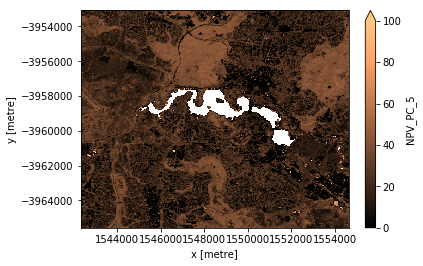

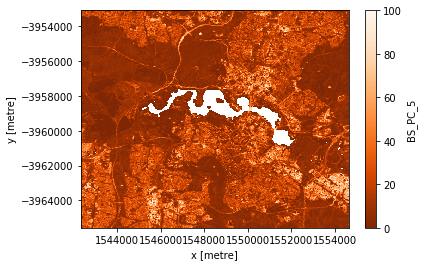

In [43]:
FC_percentiles.PV_PC_5.plot(cmap='YlGn', vmax=100)
plt.show()
FC_percentiles.NPV_PC_5.plot(cmap='copper', vmax=100)
plt.show()
FC_percentiles.BS_PC_5.plot(cmap='Oranges_r', vmax=100)
plt.show()

### Edit save file path to choose where to save your output files

In [54]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

### Save Fractional Cover percentiles to NetCDF
 - add a unit to the unitless dimension so that it writes to NetCDF

In [51]:
FC_percentiles.attrs['units'] = 'fractional_cover_percentage_percentile'

In [52]:
FC_percentiles

<xarray.Dataset>
Dimensions:     (x: 492, y: 500)
Coordinates:
  * y           (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x           (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    BS_PC_0     (y, x) float64 14.0 21.0 31.0 28.0 21.0 26.0 23.0 19.0 13.0 ...
    PV_PC_0     (y, x) float64 41.0 37.0 36.0 36.0 31.0 30.0 37.0 39.0 44.0 ...
    NPV_PC_0    (y, x) float64 29.0 19.0 8.0 5.0 8.0 4.0 7.0 15.0 20.0 17.0 ...
    BS_PC_5     (y, x) float64 14.0 24.0 33.0 30.0 27.0 31.0 26.0 24.0 14.0 ...
    PV_PC_5     (y, x) float64 42.0 39.0 39.0 37.0 34.0 33.0 38.0 40.0 45.0 ...
    NPV_PC_5    (y, x) float64 30.0 20.0 8.0 6.0 16.0 4.0 8.0 16.0 23.0 20.0 ...
    BS_PC_20    (y, x) float64 14.0 27.0 38.0 33.0 32.0 36.0 30.0 30.0 16.0 ...
    PV_PC_20    (y, x) float64 42.0 41.0 40.0 40.0 38.0 34.0 43.0 44.0 46.0 ...
    NPV_PC_20   (y, x) float64 33.0 22.0 9.0 12.0 16.0 6.0 9.0 17.0 25.0 ...
    BS_PC_50    (y, x) float64 18.0 30.0 45.0 42.0 36.0

## #Write out percentiles to NetCDF

In [56]:
try:
    DEADataHandling.write_your_netcdf(FC_percentiles, 'FC_percentiles', savefilepath+'FC_percentiles.nc', crs = ds.crs)
# #complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

wrote to netCDF


## Save Fractional Cover percentiles to GeoTiff

In [60]:
try:
    ds = FC_percentiles
    write_geotiff(savefilepath+'FC_percentiles.tif', ds)
    print('wrote to GeoTiff' )
#         DEADataHandling.write_your_netcdf(FC_quantiles.isel(quantile=quant), 'FC_Q'+str(quantiles[quant]), savefilepath+'FC_Q_'+(str(quantiles[quant]).replace('.','_'))+'.nc', crs = ds.crs)
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))

wrote to GeoTiff


## References
1. GA, 2015. *Fractional Cover (FC25) Product Description.* https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

2. TERN Auscover, 2012. *Fractional cover - Landsat, Joint Remote Sensing Research Program algorithm, Australia coverage.* Last modified by Peter Scarth on 2017/03/24 09:53. http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover